<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 18: Backpropagation
### Miscellaneous Figures

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns ; sns.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
# make plots of error surfaces
def draw_errors(plot_lo=-3, plot_hi=3, filename=None):
    fig = plt.figure(figsize=(7, 6))
    for i in [0,1]:
        target = ([0,1],[1,0])[i]
        ax = fig.add_subplot(2, 2, 1+(2*i), projection='3d')
        plot_side = 20
        x_space = np.linspace(plot_lo, plot_hi, plot_side)
        y_space = np.linspace(plot_lo, plot_hi, plot_side)
        x_grid, y_grid = np.meshgrid(x_space, y_space)
        Z = np.zeros((plot_side,plot_side))
        for px in range(plot_side):
            for py in range(plot_side):
                XY = [x_grid[px,py], y_grid[px,py]]
                Z[px, py] = (XY[0]-target[0])**2 + (XY[1]-target[1])**2
        ax.plot_surface(x_grid, y_grid, Z, rstride=1, cstride=1, cmap='cool', edgecolor='none')    

        title = 'error for target = ({:1.1f}, {:1.1f})'.format(target[0], target[1])
        plt.title(title)
        plt.xlabel('P1')
        plt.ylabel('P2')
        
        plt.subplot(2, 2, 2+(2*i))
        plt.contourf(x_grid, y_grid, Z, 15, cmap='cool')  
        plt.axvline(target[0], color='black', linewidth=.5)
        plt.axhline(target[1], color='black', linewidth=.5)
        plt.xlabel('P1')
        plt.ylabel('P2')
        plt.title(title)
        plt.colorbar() 
    plt.tight_layout()
    fig.subplots_adjust(wspace=.35)
    file_helper.save_figure(filename)
    plt.show()

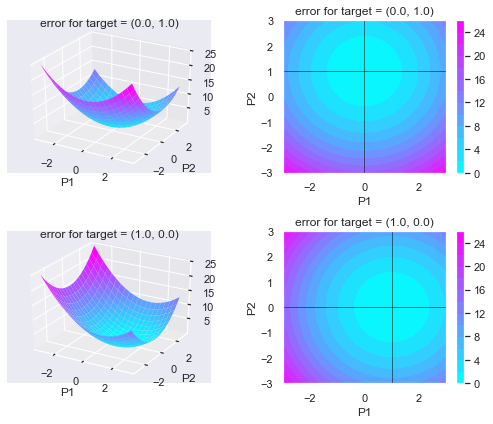

In [7]:
def draw_errors(plot_lo=-3, plot_hi=3, filename=None):
    fig = plt.figure(figsize=(7, 6))
    for i in [0,1]:
        target = ([0,1],[1,0])[i]
        ax = fig.add_subplot(2, 2, 1+(2*i), projection='3d')
        plot_side = 20
        x_space = np.linspace(plot_lo, plot_hi, plot_side)
        y_space = np.linspace(plot_lo, plot_hi, plot_side)
        x_grid, y_grid = np.meshgrid(x_space, y_space)
        Z = np.zeros((plot_side,plot_side))
        for px in range(plot_side):
            for py in range(plot_side):
                XY = [x_grid[px,py], y_grid[px,py]]
                Z[px, py] = (XY[0]-target[0])**2 + (XY[1]-target[1])**2
        ax.plot_surface(x_grid, y_grid, Z, rstride=1, cstride=1, cmap='cool', edgecolor='none')    

        title = 'error for target = ({:1.1f}, {:1.1f})'.format(target[0], target[1])
        plt.title(title)
        plt.xlabel('P1')
        plt.ylabel('P2')
        
        plt.subplot(2, 2, 2+(2*i))
        plt.contourf(x_grid, y_grid, Z, 15, cmap='cool')  
        plt.axvline(target[0], color='black', linewidth=.5)
        plt.axhline(target[1], color='black', linewidth=.5)
        plt.xlabel('P1')
        plt.ylabel('P2')
        plt.title(title)
        plt.colorbar() 
    plt.tight_layout()
    fig.subplots_adjust(wspace=.35)
    file_helper.save_figure(filename)
    plt.show()
    
draw_errors(plot_lo=-3, plot_hi=3, filename='simple-net-errors-range-3-3')

In [8]:
def draw_clipped_errors(plot_lo=-3, plot_hi=3, filename=None):
    fig = plt.figure(figsize=(6, 5))
    target = [1,0]
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    plot_side = 20
    x_space = np.linspace(plot_lo, plot_hi, plot_side)
    y_space = np.linspace(plot_lo, plot_hi, plot_side)
    x_grid, y_grid = np.meshgrid(x_space, y_space)
    Z = np.zeros((plot_side,plot_side))
    for px in range(plot_side):
        for py in range(plot_side):
            XY = [x_grid[px,py], y_grid[px,py]]
            Z[px, py] = (XY[0]-target[0])**2 + (XY[1]-target[1])**2
    for px in range(0, int(plot_side/2)):
        for py in range(plot_side):
            Z[px,py] = 0
    ax.plot_surface(x_grid, y_grid, Z, rstride=1, cstride=1, cmap='cool', edgecolor='none')

    title = 'error for target = ({:1.1f}, {:1.1f}) at P2=0'.format(target[0], target[1])
    plt.title(title)
    plt.xlabel('P1')
    plt.ylabel('P2')
    plt.ylim(-3, 3)

    plt.tight_layout()
    fig.subplots_adjust(wspace=.35)
    file_helper.save_figure(filename)
    plt.show()

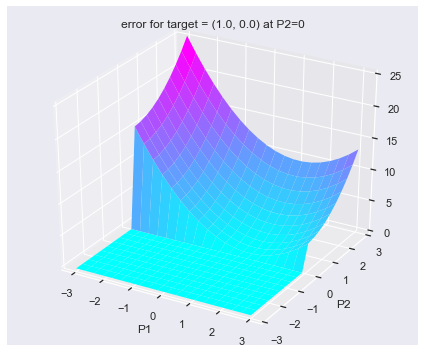

In [9]:
draw_clipped_errors(filename='error-for-P2-0')

In [10]:
def show_P1_error(range_lo=-3, range_hi=3, demo_value=-1, show_deriv=True, filename=None):
    def err(x):
        return (1-x)**2
    
    xvals = np.linspace(range_lo, range_hi, 100)
    yvals = [err(x) for x in xvals]
    plt.plot(xvals, yvals, color='black')
    plt.ylim(np.min(yvals)-.5, np.max(yvals)+.5)
    plt.scatter([demo_value], err(demo_value), s=250, c='orange', zorder=20)
    if show_deriv:
        deriv_x_left = demo_value-1
        deriv_x_right = demo_value+1
        deriv_at_demo = 2*(demo_value-1)
        deriv_y_left = err(demo_value) - deriv_at_demo
        deriv_y_right = err(demo_value) + deriv_at_demo
        plt.plot([deriv_x_left, deriv_x_right], [deriv_y_left, deriv_y_right], color='green', lw=3, zorder=30)
    plt.scatter([-1], [0], s=250, c='orange', zorder=20)
    plt.plot([-1, -1],[0, err(demo_value)], c='orange', lw=3, zorder=5)
    plt.xlabel('P1')
    plt.ylabel('error')
    plt.title('Error when P2=0 for target (1,0)')
    file_helper.save_figure(filename)
    plt.show()

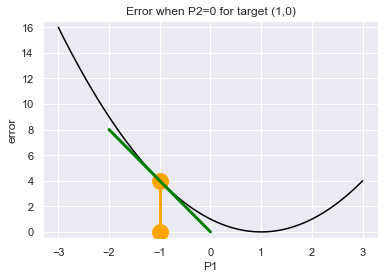

In [11]:
show_P1_error(range_lo=-3, range_hi=3, demo_value=-1, show_deriv=True, filename='error-P1-only-4-4')

In [12]:
def draw_clipped_errors_pair(plot_lo=-3, plot_hi=3, filename=None):
    fig = plt.figure(figsize=(8, 3))
    target = [1,0]
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plot_side = 20
    x_space = np.linspace(plot_lo, plot_hi, plot_side)
    y_space = np.linspace(plot_lo, plot_hi, plot_side)
    x_grid, y_grid = np.meshgrid(x_space, y_space)
    Z = np.zeros((plot_side,plot_side))
    for px in range(plot_side):
        for py in range(plot_side):
            XY = [x_grid[px,py], y_grid[px,py]]
            Z[px, py] = (XY[0]-target[0])**2 + (XY[1]-target[1])**2
    for px in range(0, int(plot_side*4.5/6)):
        for py in range(plot_side):
            Z[px,py] = 0
    ax.plot_surface(x_grid, y_grid, Z, rstride=1, cstride=1, cmap='cool', edgecolor='none')
    #ax.view_init(elev=10., azim=20)
    #ax.view_init(azim=250)
    title = 'error for target = ({:1.1f}, {:1.1f}) at P2=1.5'.format(target[0], target[1])
    plt.title(title)
    plt.xlabel('P1')
    plt.ylabel('P2')
    plt.ylim(-3, 3)
    
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    plot_side = 20
    x_space = np.linspace(plot_lo, plot_hi, plot_side)
    y_space = np.linspace(plot_lo, plot_hi, plot_side)
    x_grid, y_grid = np.meshgrid(x_space, y_space)
    Z = np.zeros((plot_side,plot_side))
    for px in range(plot_side):
        for py in range(plot_side):
            XY = [x_grid[px,py], y_grid[px,py]]
            Z[px, py] = (XY[0]-target[0])**2 + (XY[1]-target[1])**2
    for py in range(0, int(plot_side*5/12)):
        for px in range(plot_side):
            Z[px,py] = 0
    ax.plot_surface(x_grid, y_grid, Z, rstride=1, cstride=1, cmap='cool', edgecolor='none')
    
    #ax.view_init(azim=250)
    title = 'error for target = ({:1.1f}, {:1.1f}) at P1=-0.5'.format(target[0], target[1])
    plt.title(title)
    plt.xlabel('P1')
    plt.ylabel('P2')
    plt.ylim(-3, 3)

    plt.tight_layout()
    fig.subplots_adjust(wspace=.35)
    fig.subplots_adjust(hspace=.35)
    file_helper.save_figure(filename)
    plt.show()

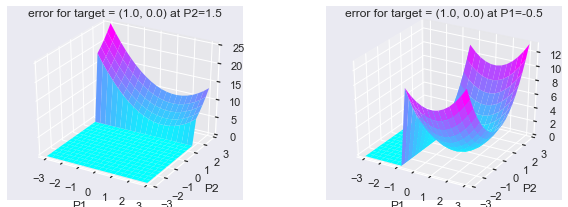

In [14]:
draw_clipped_errors_pair(filename='clipped-error-pair')

In [15]:
def show_P1_P2_error(plot_limits=[-3,3], pvals=[-.5, 1.5], target=[1,0], show_deriv=True, filename=None):
    def err(x, pval):
        if pval==0:
            return ((target[0]-x)**2) + ((target[1]-pvals[1])**2)
        else:
            return ((target[0]-pvals[0])**2) + ((target[1]-x)**2)

    fig = plt.figure(figsize=(8, 3))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        xvals = np.linspace(plot_limits[0], plot_limits[1], 100)
        yvals = [err(x, i) for x in xvals]
        plt.plot(xvals, yvals, color='black')
        #plt.ylim(np.min(yvals)-.5, np.max(yvals)+.5)
        plt.ylim(0, np.max(yvals)+.5)
        demo_value = pvals[i]
        plt.scatter([demo_value], err(demo_value, i), s=150, c='orange', zorder=20)
        plt.scatter([demo_value], [0], s=150, c='orange', zorder=20)
        plt.plot([demo_value, demo_value], [0, err(demo_value, i)], c='orange', lw=3, zorder=5)
        if show_deriv:
            deriv_x_left = demo_value-1
            deriv_x_right = demo_value+1
            deriv_at_demo = 2*(demo_value-target[i])
            deriv_y_left = err(demo_value, i) - deriv_at_demo
            deriv_y_right = err(demo_value, i) + deriv_at_demo
            plt.plot([deriv_x_left, deriv_x_right], [deriv_y_left, deriv_y_right], lw=3, color='green', zorder=30)
        pstring = 'P'+str(i+1)
        plt.xlabel(pstring)
        plt.ylabel('error')
        if i==0:
            title = 'P1 error, P2='+str(pvals[1])+', label='+str(target)
        else:
            title = 'P2 error, P1='+str(pvals[0])+', label='+str(target)
        plt.title(title)
        plt.ylim(-2, 20)
    fig.subplots_adjust(wspace=.35)
    file_helper.save_figure(filename)
    plt.show()

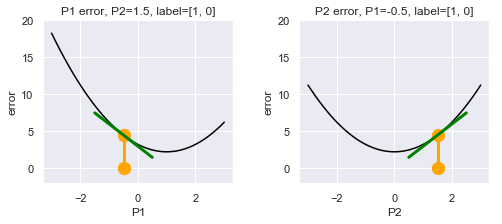

In [16]:
show_P1_P2_error(filename='error-P1-P2')

In [17]:
def sigma(x):
    return 1/(1+math.exp(-x))

def sigma_prime(x):
    s = sigma(x)
    return s*(1-s)

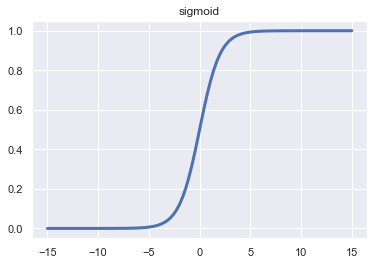

In [18]:
xrange = 15
xvals = np.linspace(-xrange, xrange, 100)
ys = [sigma(x) for x in xvals]
plt.plot(xvals, ys, lw=3)
plt.ylim(-.05, 1.05)
plt.title("sigmoid")
file_helper.save_figure('sigmoid-curve')
plt.show()

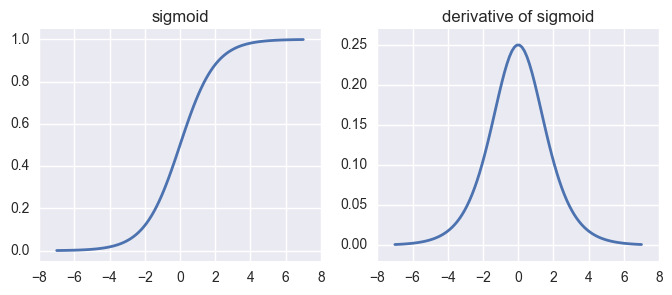

In [15]:
xrange = 7
fig = plt.figure(figsize=(8,3))
xvals = np.linspace(-xrange, xrange, 100)
ys = [sigma(x) for x in xvals]
yp = [sigma_prime(x) for x in xvals]
plt.subplot(1, 2, 1)
plt.plot(xvals, ys, lw=2)
plt.ylim(-.05, 1.05)
plt.title("sigmoid")
plt.subplot(1, 2, 2)
plt.plot(xvals, yp, lw=2)
plt.ylim(-.02, .27)
plt.title("derivative of sigmoid")
file_helper.save_figure('sigmoid-and-derivative')
plt.show()

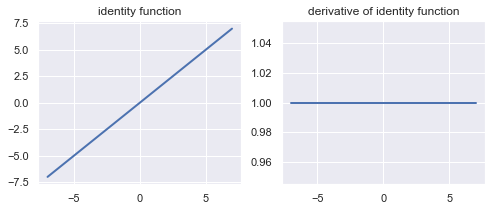

In [19]:
xrange = 7
fig = plt.figure(figsize=(8,3))
xvals = np.linspace(-xrange, xrange, 100)
ys = np.copy(xvals)
yp = [1] * len(ys)
plt.subplot(1, 2, 1)
plt.plot(xvals, ys, lw=2)
#plt.ylim(-.05, 7.05)
plt.title("identity function")
plt.subplot(1, 2, 2)
plt.plot(xvals, yp, lw=2)
#plt.ylim(-.02, .27)
plt.title("derivative of identity function")
file_helper.save_figure('identity-and-derivative')
plt.show()

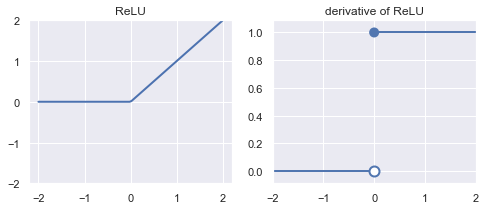

In [20]:
xrange = 2
fig = plt.figure(figsize=(8,3))
xvals = np.linspace(-xrange, xrange, 100)
ys = [x if x > 0 else 0 for x in xvals]
yp = [0 if x < 0 else 1 for x in xvals]
plt.subplot(1, 2, 1)
plt.plot(xvals, ys, lw=2)
plt.ylim(-xrange, xrange)
plt.title("ReLU")
plt.subplot(1, 2, 2)
plt.plot([-2,0],[0,0], lw=2, color='#5176b0')
plt.plot([0,2],[1,1], lw=2, color='#5176b0')
plt.scatter(0, 0, s=100, facecolor='white', lw=2, edgecolor='#5176b0', zorder=10)
plt.scatter(0, 1, s=100, facecolor='#5176b0', lw=2, edgecolor='none')
plt.xlim(-2,2)
plt.title("derivative of ReLU")
file_helper.save_figure('ReLU-and-derivative')
plt.show()

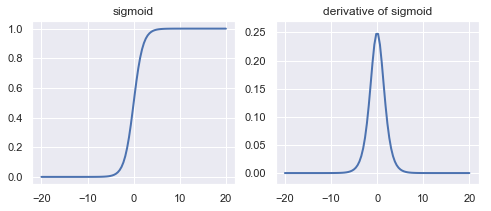

In [22]:
xrange = 20
fig = plt.figure(figsize=(8,3))
xvals = np.linspace(-xrange, xrange, 100)
ys = [sigma(x) for x in xvals]
yp = [sigma_prime(x) for x in xvals]
plt.subplot(1, 2, 1)
plt.plot(xvals, ys, lw=2)
plt.ylim(-.05, 1.05)
plt.title("sigmoid")
plt.subplot(1, 2, 2)
plt.plot(xvals, yp, lw=2)
plt.ylim(-.02, .27)
plt.title("derivative of sigmoid")
file_helper.save_figure('big-sigmoid-and-derivative')
plt.show()

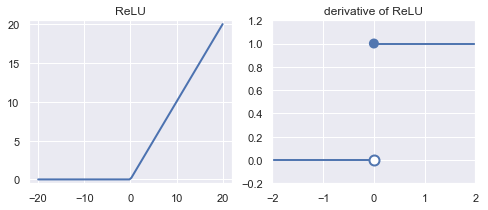

In [23]:
xrange = 20
fig = plt.figure(figsize=(8,3))
xvals = np.linspace(-xrange, xrange, 100)
ys = [x if x > 0 else 0 for x in xvals]
yp = [0 if x < 0 else 1 for x in xvals]
plt.subplot(1, 2, 1)
plt.plot(xvals, ys, lw=2)
plt.ylim(-.5, 20.5)
plt.title("ReLU")
plt.subplot(1, 2, 2)
plt.plot([-2,0],[0,0], lw=2, color='#5176b0')
plt.plot([0,2],[1,1], lw=2, color='#5176b0')
plt.scatter(0, 0, s=100, facecolor='white', lw=2, edgecolor='#5176b0', zorder=10)
plt.scatter(0, 1, s=100, facecolor='#5176b0', lw=2, edgecolor='none')
plt.xlim(-2, 2)
plt.ylim(-.2, 1.2)
plt.title("derivative of ReLU")
file_helper.save_figure('big-ReLU-and-derivative')
plt.show()